[3 2 4 3 2 4]
does the midpoint of ab lie in a or b? True
does the midpoint of bc lie in b or c? True
does the midpoint of ac lie in a or c? True
[1 1 0 1 3 0]
does the midpoint of ab lie in a or b? True
does the midpoint of bc lie in b or c? False
does the midpoint of ac lie in a or c? True
[2 0 1 2 1 0]
does the midpoint of ab lie in a or b? True
does the midpoint of bc lie in b or c? True
does the midpoint of ac lie in a or c? False


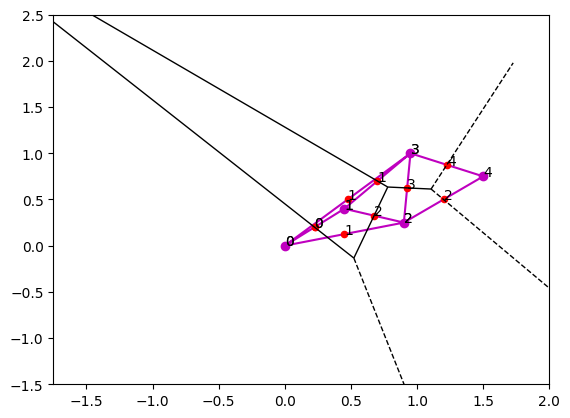

In [3]:
# https://www.geeksforgeeks.org/triangulations-using-matplotlib/
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree

# 2D array, test case from paper, we want to perform an r-limiting operation that removes edges
# from the Delaunay graph if the edges to neighboring cells lies outside the limiting radius r
points = np.array([[0,0],[0.45,0.4],[0.9,0.25],[0.95,1],[1.5,0.75]])

# perform vornoi on points, then plot it
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, show_vertices=False, point_size=2)
print(vor)
plt.xlim([-1.75,2])
plt.ylim([-1.5,2.5])

# Perform Delaunay triangulation 
tri = Delaunay(points) 
# make circles at each of the points of radius r
r = 0.5 * (2*fig.dpi)
plt.Circle((points[:,0], points[:,1]), r*1000, fill=True)

# Visualize the triangulation 
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), c='m')
plt.plot(points[:,0], points[:,1], 'mo')
plt.plot()

# rad_area = np.pi/4*r*r
# plt.scatter(points[:,0], points[:,1], s=rad_area, alpha=0.3)

for j in range(3):
    a = points[tri.simplices][j,0]
    b = points[tri.simplices][j,1]
    c = points[tri.simplices][j,2]

    qp = np.array([(a+b)/2, (b+c)/2, (c+a)/2, a, b, c])
    tree = KDTree(points)
    locs, ids = tree.query(list(qp))
    print(ids)
    
    print('does the midpoint of ab lie in a or b?', ids[0] == ids[3] or ids[0] == ids[4])
    print('does the midpoint of bc lie in b or c?', ids[1] == ids[4] or ids[1] == ids[5])
    print('does the midpoint of ac lie in a or c?', ids[2] == ids[3] or ids[2] == ids[5])

    plt.scatter(qp[:,0],qp[:,1],s=20,color='r')

    for i in range(0,len(qp[:,0])):
        plt.annotate(ids[i], (qp[i]), size = 10)

plt.show()

In [4]:
# print(vor.vertices)
print(vor.regions)
print(points[vor.ridge_points])

# print(tri.simplices)
# print(tri.neighbors)
# can use tri.find_simplex(p) for a point / an array of points

[[-1, 0], [], [3, 1, 2], [3, 0, -1, 1], [2, -1, 1], [3, 0, -1, 2]]
[[[1.5  0.75]
  [0.95 1.  ]]

 [[1.5  0.75]
  [0.9  0.25]]

 [[0.45 0.4 ]
  [0.95 1.  ]]

 [[0.45 0.4 ]
  [0.   0.  ]]

 [[0.45 0.4 ]
  [0.9  0.25]]

 [[0.95 1.  ]
  [0.   0.  ]]

 [[0.95 1.  ]
  [0.9  0.25]]

 [[0.   0.  ]
  [0.9  0.25]]]


Now that we have recreated the test case and used Vornoi, vornoi_plot_2d, and Delaunay, we can retrieve useful information from these structures. As mentioned previously, we specifically want to find whether the edges of neighboring faces are within the r-limiting radius. We need to find a way to query the available data and check distances to the source vertices (the Delaunay verts).

In [5]:
# if we know we want to check between point 0 and 2,
i = 0
j = 1

p1 = points[i]
p2 = points[j]

print('point a at i,', i, p1, 'point b at j:', j, p2)
print(points.shape)
print(vor.point_region.shape)

a = vor.point_region[i]
b = vor.point_region[j]

print('point region for point[i]: ', a)
print('point region for point[j]: ', b)

# voronoi regions at the indices
print(vor.regions[a])
print(vor.regions[b])

# common neighbors
cn = np.intersect1d(vor.regions[a], vor.regions[b])

print(cn)

def dist(a,b):
    return np.sqrt(np.abs(b[1]-a[1])**2 + np.abs(b[0]-a[0])**2)

for i in range(cn.size):
    if(cn[i] != -1):
        print('vert idx:', cn[i])
        v = vor.vertices[cn[i]]
        print('vert @', v)
        print('distance to original vertices, should be the same since its a vor vert')
        print(dist(v,p1))
        print(dist(v,p2))
        print('and they are!!!')

point a at i, 0 [0. 0.] point b at j: 1 [0.45 0.4 ]
(5, 2)
(5,)
point region for point[i]:  4
point region for point[j]:  2
[2, -1, 1]
[3, 1, 2]
[1 2]
vert idx: 1
vert @ [-2.84642857  3.65535714]
distance to original vertices, should be the same since its a vor vert
4.63290313454551
4.63290313454551
and they are!!!
vert idx: 2
vert @ [ 0.5219697  -0.13409091]
distance to original vertices, should be the same since its a vor vert
0.5389181166517448
0.5389181166517448
and they are!!!


This is useful if we need to compare vertices, but checking if neighboring edges are close enough is better. Sampling halfway along delaunay?

[4 4 4 2 4 6]

[4 5 4 4 5 6]

[1 1 1 1 2 0]

[4 4 1 1 4 2]

[3 4 3 3 5 4]

[1 1 0 3 1 0]

[1 3 4 1 3 4]



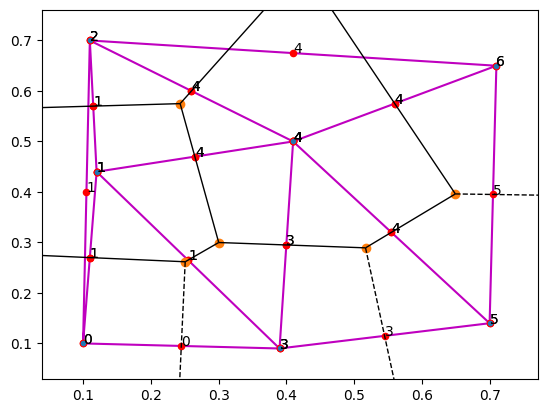

In [6]:
# https://stackoverflow.com/questions/63182111/pythonplot-scipy-plot-on-top-of-voronoi-diagram

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import voronoi_plot_2d, Voronoi, KDTree

x = [.22, .2, .4, .44, .42, .61, .17, .2, .63, .66]
y = [.21, .43, .23, .41, .42, .31, .2, .17, .62, .65]

points = np.array([[.1, .1], [.12, .44], [.11, .7], [.39, .09], [.41, .5], [.7, .14], [.71, .65]])
# points = np.array([(a+b)/2, (b+c)/2, (c+a)/2])
vor = Voronoi(points)

# tree = KDTree(points)
# locs, ids = tree.query(list(zip(x,y)))

fig,ax = plt.subplots(1,1)
voronoi_plot_2d(vor,ax)
# ax.scatter(x,y,s=20,color='r')

# for i in range(0,len(x)):
#     ax.annotate(ids[i], (x[i], y[i]), size = 10)
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), c='m')

for j in range(tri.simplices[:,0].size):
    a = points[tri.simplices][j,0]
    b = points[tri.simplices][j,1]
    c = points[tri.simplices][j,2]

    qp = np.array([(a+b)/2, (b+c)/2, (c+a)/2, a, b, c])
    tree = KDTree(points)
    locs, ids = tree.query(list(qp))
    print(ids)
    print()

    ax.scatter(qp[:,0],qp[:,1],s=20,color='r')

    for i in range(0,len(qp[:,0])):
        ax.annotate(ids[i], (qp[i]), size = 10)

plt.show()

Sampling halfway across the Delaunay edges shows us that we can check each pair of points and see if the midpoint between them lies in either of their regions or not.

Pseudocode for flocking algorithm

In [15]:
### INIT ###

# set collision shell a and sensing radius r
# init points and randomize velocities

### PROCEDURE ###

# find del/vor of points
# filter neighbors with vor/radii method
# currently O(|E|)*(2 * O(index searching)) for r-limit + O(n log n) for voronoi

## calculate forces ##

# alpha_i = - sum over r-limited neighbors of (pi - pj), 
# i.e. negative sum of difference among neighbors (alignment)

# beta_i = - sum over r-limited neighbors of the gradient of Psi(||qij||), 
# where qij = qi - qj and Psi(||qij||) = 1/(||qij||**2 - 4a**2) + 1/(r**2 - ||qij||**2)
# r is the sensing range, a is the collision range, Psi is potential function
# i.e. cohesion and seperation terms

## update position velocity and acceleration ##

# qi is position, pi is velocity, ui is acceleration.
# change in position is = to vel, change in vel = acc.
# all exist in R^n dim

# ui = alpha_i + beta_i

# d_qi = pi
# d_pi = ui

The r-limited Delaunay graph is given by the equation: $$G'_{LD}(r)(t) = (V,\Epsilon'(t))$$ with V as the vertex set of agent (V = [0,1,...,n]) and the time varying edge set with hysteresis $$\Epsilon'(t)=[(i,j)|i,j \epsilon V]$$ is defined by the following rules, given in an if A and B (and C*), then C

$$(i,j) \epsilon \Epsilon(0), 2a < ||q_i(0) - q_j(0)|| < r - \epsilon, (i,j) \epsilon \Epsilon'(0)$$
$$(i,j) \epsilon \Epsilon'(t^-), (i,j) \epsilon \Epsilon(t), (i,j) \epsilon \Epsilon'(t)$$
$$(i,j) \epsilon \Epsilon'(t^-), (i,j) \cancel{\epsilon} \Epsilon(t), (i,j) \cancel{\epsilon} \Epsilon'(t)$$
$$(i,j) \cancel{\epsilon} \Epsilon(t^-), (i,j) \epsilon \Epsilon(t), ||q_i(t) - q_j(t)|| < r - \epsilon, (i,j) \epsilon \Epsilon'(t)$$
$$(i,j) \cancel{\epsilon} \Epsilon'(t^-), (i,j) \epsilon \Epsilon(t), (i,j) \cancel{\epsilon} \Epsilon'(t)$$
where epsilon is the hysteresis value, bounded by r - sqrt(r^2 - 4a^2) and t^- is the switching time (when the edge is added or deleted happens)

Following these rules we can determine whether an edge will be added, preserved, or removed at each step.